# Importações

In [1]:
import pandas as pd

df_train = pd.read_csv(r'C:\Users\Gabriel\Desktop\dados_tiwitter\Train50.csv', sep = ";")[['tweet_text', 'query_used']]
df_train.rename(columns= {'tweet_text': 'texto', 'query_used': 'emocao'}, inplace = True)

df_test = pd.read_csv(r'C:\Users\Gabriel\Desktop\dados_tiwitter\Test.csv', sep = ";")[['tweet_text', 'query_used']]
df_test.rename(columns= {'tweet_text': 'texto', 'query_used': 'emocao'}, inplace = True)

# Pré-Processamento

In [2]:
import string
pontuacoes = string.punctuation
pontuacoes

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [3]:
from spacy.lang.pt.stop_words import STOP_WORDS
stop_words = STOP_WORDS

In [4]:
import spacy
!python3 -m spacy download pt
pln = spacy.load('pt_core_news_sm')

⚠ As of spaCy v3.0, shortcuts like 'pt' are deprecated. Please use the
full pipeline package name 'pt_core_news_sm' instead.


Traceback (most recent call last):
  File "C:\Users\Gabriel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\urllib3\connection.py", line 198, in _new_conn
    sock = connection.create_connection(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Gabriel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\urllib3\util\connection.py", line 60, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\socket.py", line 962, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
socket.gaierror: [Errno 11001] ge

In [5]:
def preprocessamento(texto):
  
  texto = texto.lower()
  documento = pln(texto)

  lista = []
  
  for token in documento:
    lista.append(token.lemma_)
    
  lista = [palavra for palavra in lista if palavra not in stop_words and palavra not in pontuacoes]
  lista = ' '.join([str(elemento) for elemento in lista if not elemento.isdigit()])

  return lista

In [6]:
df_train['texto'] = df_train['texto'].apply(preprocessamento)

In [7]:
df_train.to_csv(r'C:\Users\Gabriel\Desktop\dados_tiwitter\Train_preprocessado.csv', sep = ';')

In [8]:
df_train_final = []

for texto, emocao in zip(df_train['texto'], df_train['emocao']):
  if emocao == ':)':
    dic = ({'alegria': True, 'tristeza': False})
  elif emocao == ':(':
    dic = ({'alegria': False, 'tristeza': True})

  df_train_final.append([texto, dic.copy()])

# Criando o classificador

In [9]:
from spacy.training import Example

In [10]:
modelo = spacy.blank('pt')
textcat = modelo.add_pipe("textcat")
textcat.add_label("alegria")
textcat.add_label("tristeza")
historico = []

In [17]:
import random

modelo.begin_training()
for epoca in range(10):
  random.shuffle(df_train_final)
  losses = {}
  for batch in spacy.util.minibatch(df_train_final, 30):
    textos = [modelo(texto) for texto, entities in batch]
    annotations = [{'cats': entities} for texto, entities in batch]
    examples = [Example.from_dict(doc, annotation) for doc, annotation in zip(
            textos, annotations
        )]
    modelo.update(examples, losses=losses)
  if epoca % 1 == 0:
    print(losses)
    historico.append(losses)

{'textcat': 6.284441026729296}
{'textcat': 2.2119878724134967}
{'textcat': 0.8771963951091873}
{'textcat': 0.475556412333801}
{'textcat': 0.3598279744519019}
{'textcat': 0.6776902347818551}
{'textcat': 0.48958125988262613}
{'textcat': 0.18937509896976612}
{'textcat': 0.45827476773740744}
{'textcat': 0.10425419985377626}


In [18]:
historico_loss = []
for i in historico:
  historico_loss.append(i.get('textcat'))

In [19]:
import numpy as np

historico_loss = np.array(historico_loss)
historico_loss

array([6.28444103, 2.21198787, 0.8771964 , 0.47555641, 0.35982797,
       0.67769023, 0.48958126, 0.1893751 , 0.45827477, 0.1042542 ])

Text(0, 0.5, 'Erro')

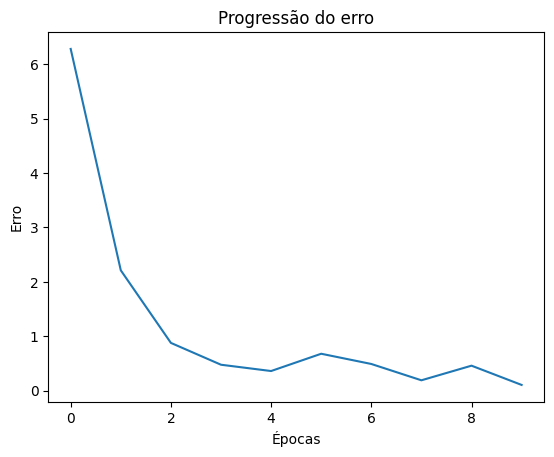

In [20]:
import matplotlib.pyplot as plt
plt.plot(historico_loss)
plt.title('Progressão do erro')
plt.xlabel('Épocas')
plt.ylabel('Erro')

In [21]:
modelo.to_disk("C:\\Users\\Gabriel\\Desktop\\dados_tiwitter\\modelo")

# Teste do modelo

In [22]:
modelo_carregado = spacy.load("C:\\Users\\Gabriel\\Desktop\\dados_tiwitter\\modelo")
modelo_carregado.analyze_pipes

<bound method Language.analyze_pipes of <spacy.lang.pt.Portuguese object at 0x000002810C28EF50>>

In [62]:
texto_positivo = 'Fico feliz com sua presença'
modelo_carregado(preprocessamento(texto_positivo)).cats

{'alegria': 0.9999450445175171, 'tristeza': 5.49904398212675e-05}

In [43]:
test_previsoes = []

for texto in df_test['texto']:
  
  previsao = modelo_carregado(texto)
  test_previsoes.append(previsao.cats)

test_previsoes_final = []

for previsao in test_previsoes:
  if previsao['alegria'] > previsao['tristeza']:
    test_previsoes_final.append(':)')
  else:
    test_previsoes_final.append(':(')

test_previsoes_final = np.array(test_previsoes_final)

test_previsoes_final

In [46]:
test_realidade_final = df_test['emocao'].values

In [49]:
from sklearn.metrics import confusion_matrix, accuracy_score
accuracy_score(test_realidade_final, test_previsoes_final)

0.9978

In [51]:
cm = confusion_matrix(test_realidade_final, test_previsoes_final)
cm

array([[2493,    7],
       [   4, 2496]], dtype=int64)